# HRTF representation learning and interpolation

Reference:

Zhang, Y., Wang, Y., & Duan, Z. (2023). [HRTF field: Unifying measured HRTF magnitude representation with neural fields.](https://ieeexplore.ieee.org/abstract/document/10095801) In Proc. IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 1-5). IEEE.

Code reference: [https://github.com/yzyouzhang/hrtf_field](https://github.com/yzyouzhang/hrtf_field).

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import numpy as np
import librosa
import soundfile as sf
from scipy.signal import fftconvolve
import sofa
import os, glob
from mpl_toolkits.mplot3d import Axes3D
from torch import nn

from torch.utils.data import DataLoader, Dataset

## Implicit Neural Representation (Neural Field)

Implicit neural representation, also known as a neural field, is a method of representing discrete data with a continuous function. This approach uses a neural network to map input coordinates to output values, effectively creating a continuous representation of the data.

The function can be expressed as:

$$  f_\theta(\mathbf{x}) = \mathbf{y}  $$

where:
- $ f_\theta $ is the neural network parameterized by \(\theta\),
- $ \mathbf{x}$ is the input coordinate (e.g., spatial coordinates),
- $ \mathbf{y}$  is the output value (e.g., intensity, color, or any other property).

This allows for smooth interpolation and continuous representation of the data.

Reference lecture slides: [Link](https://www.cs.toronto.edu/~lindell/teaching/2529/2022/slides/lecture10.pdf)



## Introduction to Head-Related Transfer Function (HRTF)

Head-Related Transfer Function (HRTF) is a response that characterizes how an ear receives a sound from a point in space. It is a function that describes how the ear transforms sound waves arriving from different directions into the signals that are perceived by the brain. HRTFs are used to simulate how sounds are heard from different locations, which is crucial for creating realistic 3D audio experiences.

Key Points about HRTF:
* Spatial Filtering: HRTFs capture the effects of the head, torso, and outer ear (pinna) on the sound waves, which include reflections, diffractions, and absorptions.
* Directionality: HRTFs are direction-dependent, meaning they vary based on the azimuth (horizontal angle) and elevation (vertical angle) of the sound source relative to the listener.
* Frequency Response: HRTFs also vary with frequency, as different frequencies are affected differently by the shape and structure of the head and ears.

# Warm up on HRTF data

HRTFs are defined in the continuous space and describe how an ear receives a sound from a point in space. The HRTF can be expressed as a function of the direction of the sound source and the frequency of the sound.

The formula for HRTF is:

$$ H(\theta, \phi, f) $$

where:
- $ H $ is the HRTF,
- $ \theta $ is the azimuth angle (horizontal direction),
- $\phi$ is the elevation angle (vertical direction),
- $ f $ is the frequency of the sound.

This function captures the spatial filtering effects of the head, torso, and outer ear, providing a unique signature for each direction and frequency.

We first pick the HRTF of one individual and open the SOFA file containing the HRTF data.

For learning more about SOFA, visit https://www.sofaconventions.org/mediawiki/index.php/SOFA_(Spatially_Oriented_Format_for_Acoustics)

For learning more about analyzing SOFA file with Python, visit https://python-sofa.readthedocs.io/en/latest/


### Download the HUTUBS dataset

Please download the `HRIR.zip` from https://depositonce.tu-berlin.de/items/dc2a3076-a291-417e-97f0-7697e332c960 and then unzip it to `../data/`.

In [2]:
pp2_HRTF = sofa.Database.open('../data/HRIRs/pp2_HRIRs_measured.sofa')

Below, I plotted the source positions in 3D space. The x-axis represents the left-right position, the y-axis represents the front-back position, and the z-axis represents the up-down position. This shows all the source positions of HRTFs measured in this 3D3A dataset.

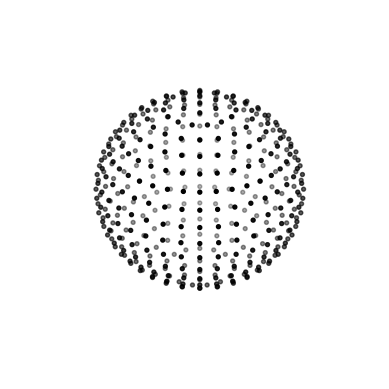

In [3]:
source_positions_cartesian = pp2_HRTF.Source.Position.get_values(system="cartesian")

# Unpack the coordinates for plotting
x, y, z = zip(*source_positions_cartesian)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, s=8, c='k')

# Turn off the grid
ax.grid(False)
# Remove grid, tick labels, and axis
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()

# # Remove the box around the plot
# ax.set_frame_on(False)

# Set equal aspect ratio for all axes to make the plot more spherical
scale_ratio = 0.88
max_range = np.array([np.max(np.abs(x)), np.max(np.abs(y)), np.max(np.abs(z))]).max()
ax.set_zlim(-max_range * scale_ratio, max_range * scale_ratio)

# Show the plot
plt.show()

## Fit a Single Person's HRTF with a Neural Field Model

In this section, we aim to represent a single person's Head-Related Transfer Function (HRTF) using a neural field model. By using a neural field model to represent HRTF, we can achieve a continuous and smooth representation of the HRTF across different directions. This approach allows for efficient interpolation and extrapolation of HRTF data.



In [4]:
# Build a neural field

# a SIREN layer as in https://vsitzmann.github.io/siren/
class SirenLayer(nn.Module):
    def __init__(self, in_f, out_f, w0=30, is_first=False, is_last=False):
        super().__init__()
        self.in_f = in_f
        self.w0 = w0
        self.linear = nn.Linear(in_f, out_f)
        self.is_first = is_first
        self.is_last = is_last
        self.init_weights()

    def init_weights(self):
        b = 1 / self.in_f if self.is_first else np.sqrt(6 / self.in_f) / self.w0
        with torch.no_grad():
            self.linear.weight.uniform_(-b, b)

    def forward(self, x):
        x = self.linear(x)
        return x if self.is_last else torch.sin(self.w0 * x)


def build_model(dimensions):
    first_layer = SirenLayer(dimensions[0], dimensions[1], is_first=True)
    other_layers = []
    # other_layers.append(nn.LayerNorm(dimensions[1]))
    for dim0, dim1 in zip(dimensions[1:-2], dimensions[2:-1]):
        other_layers.append(SirenLayer(dim0, dim1))
        # other_layers.append(nn.LayerNorm(dim1))
    final_layer = SirenLayer(dimensions[-2], dimensions[-1], is_last=True)
    return nn.Sequential(first_layer, *other_layers, final_layer)

In [5]:
class HRTFField(nn.Module):
    def __init__(self, dimensions):
        super().__init__()
        self.net = build_model(dimensions)

    def forward(self, x):
        return self.net(x)

In [6]:
# Prepare the input data
source_positions_spherical = pp2_HRTF.Source.Position.get_values(system="spherical")

pp2_HRTF_HRIRs = pp2_HRTF.Data.IR.get_values()

pp2_HRTF_HRFRs = np.abs(np.fft.fft(pp2_HRTF_HRIRs, axis=-1))[:, 0, :128] # As we are using 256-point FFT, we only need the first 128 bins
# pp2_HRTF_HRFRs_log = 20 * np.log(pp2_HRTF_HRFRs)

input_coordinates = torch.tensor(source_positions_spherical[:, :2], dtype=torch.float32)

output_data = torch.tensor(pp2_HRTF_HRFRs, dtype=torch.float32)

# Define the dimensions of the model
dimensions = [2, 256, 256, 128]  # Example dimensions, adjust as needed

# Initialize the HRTFField model
hrtf_field = HRTFField(dimensions)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(hrtf_field.parameters(), lr=1e-4 * 2)

# Training loop
num_epochs = 600  # Example number of epochs, adjust as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = hrtf_field(input_coordinates)
    loss = criterion(output, output_data)  # Example loss, adjust as needed
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(hrtf_field.state_dict(), 'hrtf_field_model.pth')

Epoch [100/600], Loss: 0.5051
Epoch [200/600], Loss: 0.3389
Epoch [300/600], Loss: 0.2011
Epoch [400/600], Loss: 0.1145
Epoch [500/600], Loss: 0.0720
Epoch [600/600], Loss: 0.0507


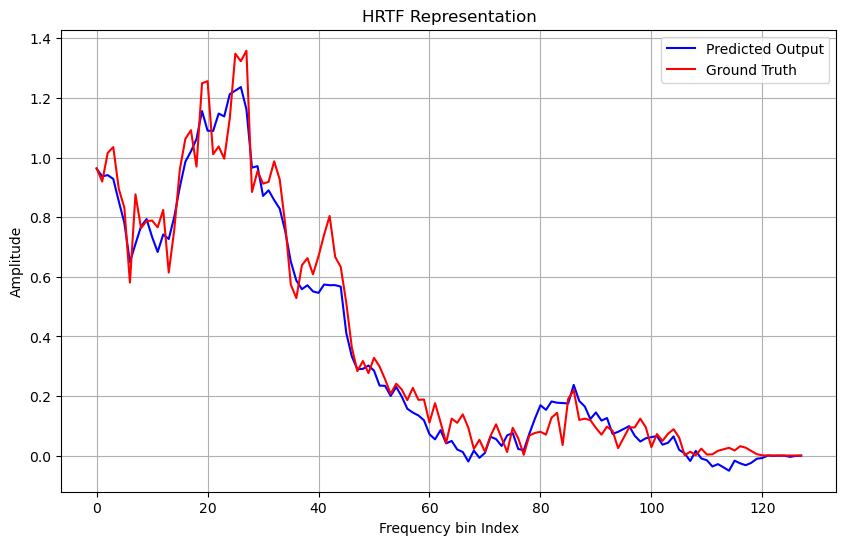

In [7]:
# Compare a single HRTF prediction with the ground truth

location_index = 120  # Example location index, adjust as needed

plt.figure(figsize=(10, 6))
plt.plot(output[location_index].detach().numpy(), color='blue', label='Predicted Output')
plt.plot(output_data[location_index].detach().numpy(), color='red', label='Ground Truth')
plt.xlabel('Frequency bin Index')
plt.ylabel('Amplitude')
plt.title('HRTF Representation')
plt.legend()
plt.grid(True)
plt.show()

The training process is quite fast, and the field model can fit the data very well. With this trained neural network, we can now represent the HRTF as a continuous function. By inputting the coordinates, the model can predict the HRTF at those specific locations.

## A generative model to learn HRTF representation and perform interpolation

We will use the HUTUBS dataset to learn a generative model to perform HRTF interpolation.

In [8]:
# data loader to load the HUTUBS HRTF data

class HUTUBS(Dataset):
    def __init__(self):
        super(HUTUBS, self).__init__()
        self.sofa_dir = os.path.join("../data/HRIRs")
        self.file_list = self._get_all_sofa_files_from_dir()

    def _get_all_sofa_files_from_dir(self):
        return glob.glob(os.path.join(self.sofa_dir, "*HRIRs_measured.sofa"))

    def _get_ID_from_sofa_path(self, path):
        return os.path.basename(path).split("_")[0][2:]

    def _get_sofa_path_from_ID(self, subject_ID):
        return os.path.join(self.sofa_dir, "pp%d_HRIRs_measured.sofa" % int(subject_ID))
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        path = self.file_list[idx]
        sofa_file = sofa.Database.open(path)
        hrir = sofa_file.Data.IR.get_values()
        hrfr = np.abs(np.fft.fft(hrir, axis=-1))[:, 0, :128]
        # hrfr_log = 20 * np.log(hrfr)
        source_positions = sofa_file.Source.Position.get_values(system="spherical")
        subject_ID = self._get_ID_from_sofa_path(path)
        return torch.tensor(source_positions[:, :2], dtype=torch.float32), torch.tensor(hrfr, dtype=torch.float32), subject_ID
    
hutubs = HUTUBS()

In [9]:
print(len(hutubs))
loc, hrfr, sub_id = hutubs[0]
print(loc.shape, hrfr.shape, sub_id)

96
torch.Size([440, 2]) torch.Size([440, 128]) 11


In [10]:
# overfitting setting (reconstruction)

train_set, test_set = torch.utils.data.random_split(hutubs, [0.83, 0.17])
print(len(train_set), len(test_set))

trainDataLoader = DataLoader(train_set, batch_size=16, shuffle=True)
testDataLoader = DataLoader(test_set, batch_size=16, shuffle=False)
# print(len(trainDataLoader))

80 16


The input will need to be concatenated with a z vector to represent the subject information.

In [11]:
z_dim = 14
dimensions = [2+z_dim, 256, 256, 128]  # Example dimensions, adjust as needed

In [12]:
class HRTFField(nn.Module):
    def __init__(self, dimensions):
        super().__init__()
        self.net = build_model(dimensions)
        # self.relu = nn.ReLU()

    def forward(self, loc, z):
        x = torch.concat([loc, z], axis=-1)
        return self.net(x)
    
    def z2loss(self, locs, hrtfs, z):
        # (batch_size, num_locs, z_dims)
        z_rep = z.repeat(1, locs.size(1), 1)
        # network input: (batch_size, num_locs, z_dims + 2)
        g = self.forward(locs, z_rep)
        # print(g.shape, hrtfs.shape)
        L = torch.mean((g - hrtfs) ** 2)

        return L, g
    
    def inner_loss(self, locs, hrtfs):
        # compute the gradients of the inner loss with respect to zeros (gradient origin)
        # (batch_size, 1, z_dims)
        z = (
            torch.zeros(locs.shape[0], 1, z_dim)
            .requires_grad_()
        )

        L_inner, _ = self.z2loss(locs, hrtfs, z)

        z = -torch.autograd.grad(L_inner, [z], create_graph=False, retain_graph=False)[
            0
        ]

        return L_inner, z
    
    def outer_loss(self, locs, hrtfs, z):
        # now with the new latent points z, optimize the reproduction error
        L_outer, g = self.z2loss(locs, hrtfs, z)

        return L_outer, g
    
    def training_step(self, batch, batch_idx):
        locs, hrtfs, sub_id = batch
        L_inner, z = self.inner_loss(locs, hrtfs)
        L_outer, g = self.outer_loss(locs, hrtfs, z)

        return L_outer, g
    
    def validation_step(self, batch, batch_idx, method="full"):
        torch.set_grad_enabled(True)
        if method == "partial":
            locs_obs, hrtfs_obs, locs_unobs, hrtfs_unobs, sub_id = batch

            L_inner, z = self.inner_loss(locs_obs, hrtfs_obs)

            # now with the new latent points z, measure reproduction error
            # use only unobesrvable locations
            with torch.no_grad():
                L_outer, g = self.outer_loss(locs_unobs, hrtfs_unobs, z)

        else:
            locs, hrtfs, sub_id = batch

            L_inner, z = self.inner_loss(locs, hrtfs)

            with torch.no_grad():
                L_outer, g = self.outer_loss(locs, hrtfs, z)
        
        return L_outer, g


In [ ]:
def LSD_metrics(x, g):
    lsd_matrix = torch.square(20 * torch.log10(torch.abs(x) / torch.abs(g)))
    return torch.sqrt(torch.mean(lsd_matrix))

def keras_decay(step, decay=0.01):
    """Learning rate decay in Keras-style"""
    return 1.0 / (1.0 + decay * step)

def train_one_epoch(trainDataLoader, F, optim, lr_scheduler):
    F.train()
    for i, batch in enumerate(trainDataLoader):
        locs, x, sub_id = batch
        L_outer, g = F.training_step(batch, i)
        # print(g, x)
        optim.zero_grad()
        L_outer.backward()
        optim.step()
        lsd = LSD_metrics(x, g)
        lr_scheduler.step()
    
    print(f"Training Epoch [{epoch + 1}], l_out: {L_outer.item()}, lsd: {lsd.item()}")

    return F, optim, lr_scheduler

def test_one_epoch(validationDataLoader, F):
    F.eval()
    for i, batch in enumerate(validationDataLoader):
        locs, x, sub_id = batch
        L_outer, g = F.validation_step(batch, i)
        lsd = LSD_metrics(x, g)
    
    print(f"Testing Epoch [{epoch + 1}], l_out: {L_outer.item()}, lsd: {lsd.item()}")

    return F, L_outer, lsd


In [14]:
num_epochs = 100
lr = 5 * 1e-4

model = HRTFField(dimensions)
optim = torch.optim.Adam(lr=lr, params=model.parameters(), weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
        optim, lr_lambda=lambda step: keras_decay(step, 0.005)
    )

for epoch in range(num_epochs):
    # print("Epoch: %03d" % epoch)

    model, optim, lr_scheduler = train_one_epoch(trainDataLoader, model, optim, lr_scheduler)

    model, L_outer, lsd = test_one_epoch(testDataLoader, model)


Training Epoch [1], l_out: 2.976882219314575, lsd: 16.57976531982422
Testing Epoch [1], l_out: 2.932147741317749, lsd: 15.289887428283691
Training Epoch [2], l_out: 1.9182045459747314, lsd: 14.082487106323242
Testing Epoch [2], l_out: 2.1307637691497803, lsd: 13.628804206848145
Training Epoch [3], l_out: 1.4939521551132202, lsd: 13.295445442199707
Testing Epoch [3], l_out: 1.6637234687805176, lsd: 13.073647499084473
Training Epoch [4], l_out: 1.2117506265640259, lsd: 11.897218704223633
Testing Epoch [4], l_out: 1.3515715599060059, lsd: 11.987740516662598
Training Epoch [5], l_out: 1.0904276371002197, lsd: 11.237275123596191
Testing Epoch [5], l_out: 1.1195800304412842, lsd: 11.036486625671387
Training Epoch [6], l_out: 0.7296745181083679, lsd: 10.160543441772461
Testing Epoch [6], l_out: 0.9565357565879822, lsd: 10.344905853271484
Training Epoch [7], l_out: 0.8936894536018372, lsd: 10.058568954467773
Testing Epoch [7], l_out: 0.8552961349487305, lsd: 10.224666595458984
Training Epoch [

## Extended Reading

Wen, Y., Zhang, Y., & Duan, Z. (2023, October). Mitigating Cross-Database Differences for Learning Unified HRTF Representation. In 2023 IEEE Workshop on Applications of Signal Processing to Audio and Acoustics (WASPAA) (pp. 1-5). IEEE.

Masuyama, Y., Wichern, G., Germain, F. G., Pan, Z., Khurana, S., Hori, C., & Le Roux, J. (2024, April). NIIRF: Neural IIR Filter Field for HRTF Upsampling and Personalization. In ICASSP 2024-2024 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 1016-1020). IEEE.

Lobato, T., & Sottek, R. (2024, August). A Process for Calibrating HRTFs Based on Differentiable Implicit Representations and Domain Adversarial Learning. In 2024 32nd European Signal Processing Conference (EUSIPCO) (pp. 271-275). IEEE.
